In [ ]:
!pip install boto3 aiohttp asyncio

In [ ]:
!pip install joblib

In [ ]:
import asyncio
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import time
from getpass import getpass
import asyncio
import aiohttp
import boto3
import time
from concurrent.futures import ThreadPoolExecutor
import joblib

In [ ]:
aws_access_key_id = getpass("Access Key: ")
aws_secret_access_key = getpass("Secret Key: ")

session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name="us-east-2"
)
s3 = session.client("s3")
textract = session.client("textract")

Access Key: ··········
Secret Key: ··········


In [ ]:
def list_pdf_files(bucket_name):
    paginator = s3.get_paginator('list_objects_v2')
    operation_parameters = {
        'Bucket': bucket_name,
        'Prefix': 'test/'
    }
    page_iterator = paginator.paginate(**operation_parameters)

    pdf_files = []
    for page in page_iterator:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.endswith('.pdf'):
                pdf_files.append((key))
    return pdf_files

bucket_name = "melichallegebucket"
pdf_files = list_pdf_files(bucket_name)
print("Cantidad de documentos encontrados:", len(pdf_files))

Cantidad de documentos encontrados: 39


In [ ]:
async def load_pdf_and_start_textract(file_key: str, bucket_name: str):
    if not file_key.startswith("test/"):
        return None

    s3 = session.client('s3')
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    file_bytes = response['Body'].read()

    loop = asyncio.get_event_loop()
    job_id = await loop.run_in_executor(None, lambda: textract.start_document_text_detection(
        DocumentLocation={'S3Object': {'Bucket': bucket_name, 'Name': file_key}}
    )['JobId'])

    return {"job_id": job_id, "file_key": file_key}

In [ ]:
def get_textract_result(job_id):
    while True:
        response = textract.get_document_text_detection(JobId=job_id)
        status = response['JobStatus']
        if status == 'SUCCEEDED':
            blocks = response['Blocks']
            lines = [b["Text"] for b in blocks if b["BlockType"] == "LINE"]
            return " ".join(lines)
        elif status == 'FAILED':
            return ""
        time.sleep(5)

In [ ]:
async def process_all_files(file_list, bucket_name):
    loop = asyncio.get_event_loop()
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [
            load_pdf_and_start_textract(file_key, bucket_name)
            for file_key in file_list
        ]
        jobs = await asyncio.gather(*futures)

        results = []
        for job in jobs:
            text = await loop.run_in_executor(executor, get_textract_result, job['job_id'])
            results.append({
                "filename": job["file_key"],
                "text": text
            })
        return results

In [ ]:
def save_results_to_csv(results, filename="extract_text_test.csv"):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print("CSV guardado como", filename)

In [ ]:
results = await process_all_files(pdf_files, bucket_name)

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,filename,text
0,test/certificado1.pdf,E.P.S.Sanitas Sanitas Internacional CERTIFICAD...
1,test/certificado10.pdf,VIGILADO SUPERINTENDENCIA FINANCIERA EMPRESA I...
2,test/certificado2.pdf,CERTIFICADO DE ANTECEDENTES PIB 09:55:21 PROCU...
3,test/certificado3.pdf,"Personería de Bogotá, D.C. CERTIFICADO ORDINAR..."
4,test/certificado4.pdf,CONTRALORÍA GENERAL DE LA REPUBLICA LA CONTRAL...
5,test/certificado5.pdf,Consejo Profesional Nacional de Ingenierías El...
6,test/certificado6.pdf,COLOMBIA POTENCIA DE LA VIDA 9 Colpensiones LA...
7,test/certificado7.pdf,COLOMBIA POTENCIA DE LA TIC VIDA MINISTERIO DE...
8,test/certificado8.pdf,"Certificación Bancaria Domingo, 17 de marzo de..."
9,test/certificado9.pdf,Colsubsidio Con todo lo que te mereces LA CAJA...


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

In [ ]:
results_df = pd.read_csv("resultados.csv")

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

In [ ]:
modelos = [
    "logistic regression",
    "linear svm",
    "random forest",
    "multinomial nb",
]

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("spanish"))
stemmer = SnowballStemmer("spanish")
tokenizer = RegexpTokenizer(r'\b\w+\b')

In [ ]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"\s+", " ", texto).strip()
    tokens = tokenizer.tokenize(texto)
    tokens = [stemmer.stem(palabra) for palabra in tokens if palabra not in stop_words]
    return " ".join(tokens)

In [ ]:
results_df["text"] = results_df["text"].apply(limpiar_texto)

In [ ]:
def extraer_categoria(filename):
    nombre = filename.split("/")[1]
    base = re.findall(r"[a-zA-Z]+", nombre)[0].lower()
    if base == "resolucion":
        return "resoluciones"
    else:
        return base + "s"


In [ ]:
results_df["categoria_real"] = results_df["filename"].apply(extraer_categoria)

In [ ]:
for nombre in modelos:
    modelo_path = f"modelo_{nombre}_documentos.pkl"
    modelo = joblib.load(modelo_path)

    y_pred = modelo.predict(results_df["text"])
    col_name = f"pred_{nombre.replace(' ', '_')}"
    results_df[col_name] = y_pred


=== Resultados para: LOGISTIC REGRESSION ===
Accuracy :  0.7949
Precision:  0.8688
Recall   :  0.7949
F1 Score :  0.7698

Reporte de Clasificación:
              precision    recall  f1-score   support

certificados       0.59      1.00      0.74        10
   contratos       0.89      0.89      0.89         9
    facturas       1.00      1.00      1.00        10
resoluciones       1.00      0.30      0.46        10

    accuracy                           0.79        39
   macro avg       0.87      0.80      0.77        39
weighted avg       0.87      0.79      0.77        39



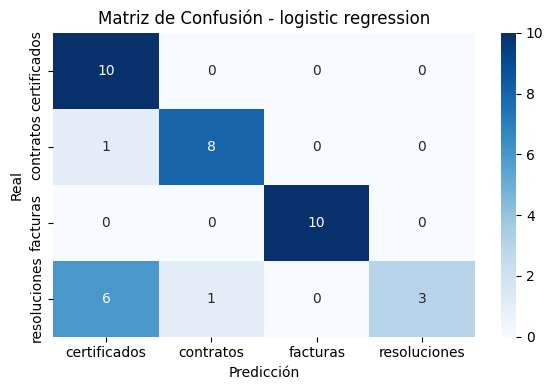


=== Resultados para: LINEAR SVM ===
Accuracy :  0.8205
Precision:  0.8624
Recall   :  0.8205
F1 Score :  0.8103

Reporte de Clasificación:
              precision    recall  f1-score   support

certificados       0.67      1.00      0.80        10
   contratos       0.88      0.78      0.82         9
    facturas       0.91      1.00      0.95        10
resoluciones       1.00      0.50      0.67        10

    accuracy                           0.82        39
   macro avg       0.86      0.82      0.81        39
weighted avg       0.86      0.82      0.81        39



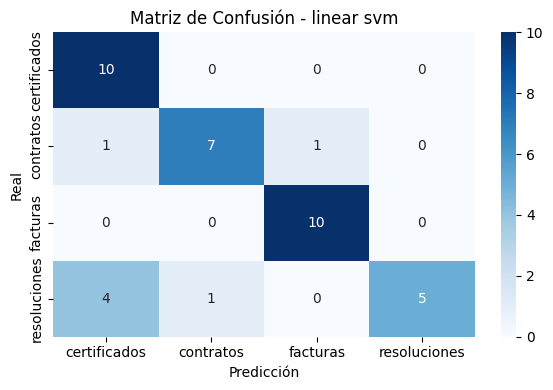


=== Resultados para: RANDOM FOREST ===
Accuracy :  0.9231
Precision:  0.9301
Recall   :  0.9231
F1 Score :  0.9241

Reporte de Clasificación:
              precision    recall  f1-score   support

certificados       0.82      0.90      0.86        10
   contratos       1.00      0.89      0.94         9
    facturas       0.91      1.00      0.95        10
resoluciones       1.00      0.90      0.95        10

    accuracy                           0.92        39
   macro avg       0.93      0.92      0.92        39
weighted avg       0.93      0.92      0.92        39



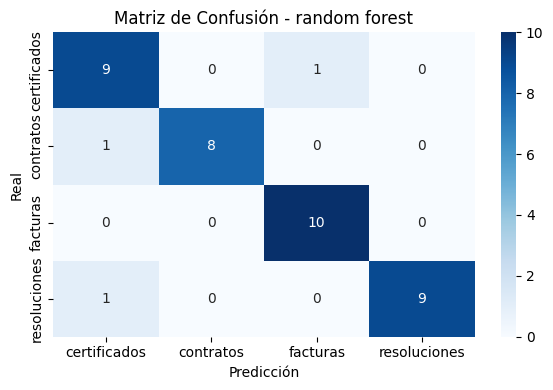


=== Resultados para: MULTINOMIAL NB ===
Accuracy :  0.9487
Precision:  0.9573
Recall   :  0.9487
F1 Score :  0.9496

Reporte de Clasificación:
              precision    recall  f1-score   support

certificados       1.00      1.00      1.00        10
   contratos       1.00      0.89      0.94         9
    facturas       1.00      0.90      0.95        10
resoluciones       0.83      1.00      0.91        10

    accuracy                           0.95        39
   macro avg       0.96      0.95      0.95        39
weighted avg       0.96      0.95      0.95        39



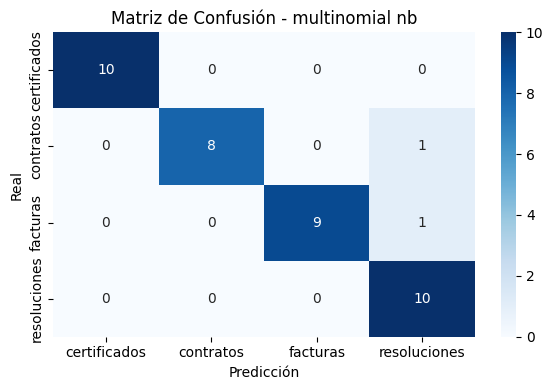

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Lista con los nombres de tus modelos y sus columnas de predicción
nombres_modelos = [
    "logistic regression",
    "linear svm",
    "random forest",
    "multinomial nb"
]

for nombre in nombres_modelos:
    col_pred = f"pred_{nombre.replace(' ', '_')}"
    print(f"\n=== Resultados para: {nombre.upper()} ===")

    # Métricas
    y_true = results_df["categoria_real"]
    y_pred = results_df[col_pred]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1 Score :  {f1:.4f}")

    # Reporte detallado
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred))

    # Matriz de Confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        confusion_matrix(y_true, y_pred),
        annot=True,
        fmt="d",
        xticklabels=sorted(results_df["categoria_real"].unique()),
        yticklabels=sorted(results_df["categoria_real"].unique()),
        cmap="Blues"
    )
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


In [ ]:
results_df.to_csv("resultados.csv", index=False)